In [1]:
import cv2
import numpy as np
from pathlib import Path


In [2]:
def preprocess_for_detector(
    img: np.ndarray,
    short_side_target: int = 736,
    max_side_limit: int = 2400,
    stride: int = 32,
):
    """
    ページ全体を対象とした検出器（CNN / FCN）向け前処理

    処理内容:
    1. 短辺を short_side_target に合わせて等比スケーリング
    2. 長辺が max_side_limit を超える場合は縮小
    3. H, W を stride の倍数に丸める
    4. float32 化 + 正規化
    """

    h, w = img.shape[:2]

    # --- 1. 短辺基準でスケール ---
    short_side = min(h, w)
    scale = short_side_target / short_side

    # --- 2. 長辺が上限を超える場合は抑制 ---
    long_side = max(h, w)
    if long_side * scale > max_side_limit:
        scale = max_side_limit / long_side

    new_h = int(h * scale)
    new_w = int(w * scale)

    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # --- 3. stride の倍数に丸める ---
    def round_to_stride(x):
        return (x // stride) * stride

    aligned_h = round_to_stride(new_h)
    aligned_w = round_to_stride(new_w)

    resized = resized[:aligned_h, :aligned_w]

    # --- 4. 正規化（モデル依存だが代表例） ---
    resized = resized.astype(np.float32) / 255.0
    resized = (resized - 0.5) / 0.5  # [-1, 1] 正規化例

    return resized

In [3]:
def preprocess_for_recognizer(
    roi: np.ndarray,
    target_h: int = 64,
    target_w: int = 256,
    pad_value: int = 0,
):
    """
    文字認識器向け前処理（固定サイズ入力）

    処理内容:
    1. ROI をアスペクト比維持で縮小（超過分のみ）
    2. 足りない領域をパディング
    3. 固定サイズ (H, W) に揃える
    """

    h, w = roi.shape[:2]

    # --- 1. 縮小率を計算（拡大はしない） ---
    scale = min(target_w / w, target_h / h, 1.0)

    new_w = int(w * scale)
    new_h = int(h * scale)

    resized = cv2.resize(roi, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # --- 2. パディング用キャンバス作成 ---
    canvas = np.full(
        (target_h, target_w, 3),
        pad_value,
        dtype=resized.dtype,
    )

    # 左上配置（中央配置にしたい場合はオフセット調整）
    canvas[:new_h, :new_w] = resized

    # --- 3. 正規化 ---
    canvas = canvas.astype(np.float32) / 255.0
    canvas = (canvas - 0.5) / 0.5

    return canvas


In [4]:
def preprocess_for_layout(
    img: np.ndarray,
    target_h: int = 1024,
    target_w: int = 768,
):
    """
    レイアウト解析モデル向け前処理

    処理内容:
    1. 固定サイズへ強制リサイズ
    2. 正規化
    """

    resized = cv2.resize(
        img,
        (target_w, target_h),
        interpolation=cv2.INTER_LINEAR,
    )

    resized = resized.astype(np.float32) / 255.0
    resized = (resized - 0.5) / 0.5

    return resized


Original shape: (375, 500, 3)
Original dtype: uint8
Original range: [0.000, 255.000]

Detector preprocessed shape: (736, 960, 3)
Detector preprocessed dtype: float32
Detector preprocessed range: [-1.000, 1.000]

Recognizer preprocessed shape: (64, 256, 3)
Recognizer preprocessed dtype: float32
Recognizer preprocessed range: [-1.000, 1.000]

Layout preprocessed shape: (1024, 768, 3)
Layout preprocessed dtype: float32
Layout preprocessed range: [-1.000, 1.000]


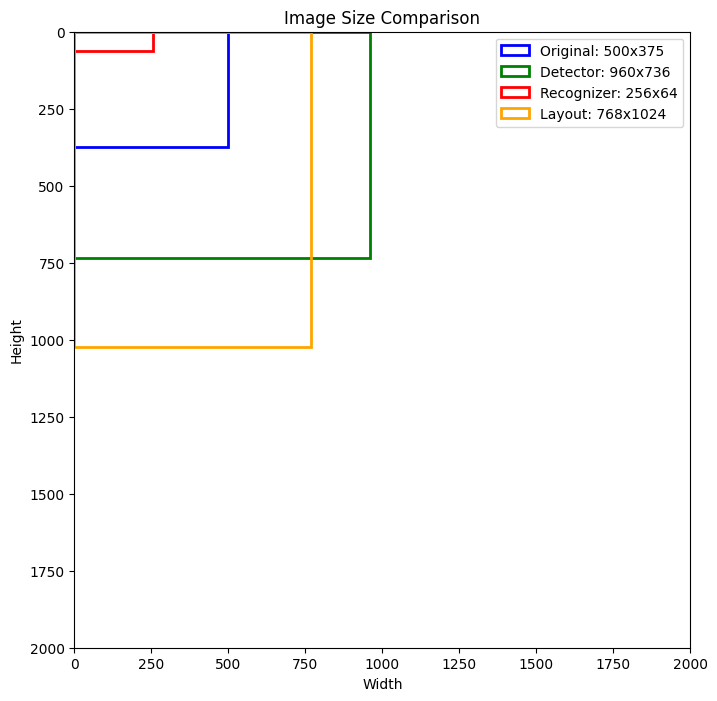

In [87]:
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

image_path = Path("./sample_data/sample_jpg.jpg")
image_path = random.choice(list(Path("./sample_data").glob("**/*.jpg")))
image = cv2.imread(image_path)

preprocessed_image_for_detector = preprocess_for_detector(image)
preprocess_image_for_recognizer = preprocess_for_recognizer(image)
preprocess_image_for_layout = preprocess_for_layout(image)


print("Original shape:", image.shape)
print("Original dtype:", image.dtype)
print("Original range: [{:.3f}, {:.3f}]".format(image.min(), image.max()))
print()
print("Detector preprocessed shape:", preprocessed_image_for_detector.shape)
print("Detector preprocessed dtype:", preprocessed_image_for_detector.dtype)
print("Detector preprocessed range: [{:.3f}, {:.3f}]".format(preprocessed_image_for_detector.min(), preprocessed_image_for_detector.max()))
print()
print("Recognizer preprocessed shape:", preprocess_image_for_recognizer.shape)
print("Recognizer preprocessed dtype:", preprocess_image_for_recognizer.dtype)
print("Recognizer preprocessed range: [{:.3f}, {:.3f}]".format(preprocess_image_for_recognizer.min(), preprocess_image_for_recognizer.max()))
print()
print("Layout preprocessed shape:", preprocess_image_for_layout.shape)
print("Layout preprocessed dtype:", preprocess_image_for_layout.dtype)
print("Layout preprocessed range: [{:.3f}, {:.3f}]".format(preprocess_image_for_layout.min(), preprocess_image_for_layout.max()))


# 各画像のshape (height, width)
shapes = [
    ("Original", image.shape[0], image.shape[1]),
    ("Detector", preprocessed_image_for_detector.shape[0], preprocessed_image_for_detector.shape[1]),
    ("Recognizer", preprocess_image_for_recognizer.shape[0], preprocess_image_for_recognizer.shape[1]),
    ("Layout", preprocess_image_for_layout.shape[0], preprocess_image_for_layout.shape[1]),
]

# 最大サイズを取得
max_h = max(h for _, h, _ in shapes)
max_w = max(w for _, _, w in shapes)

fig, ax = plt.subplots(figsize=(8, 8))
colors = ["blue", "green", "red", "orange"]

for (label, h, w), color in zip(shapes, colors):
    rect = patches.Rectangle((0, 0), w, h, linewidth=2, edgecolor=color, facecolor='none', label=f"{label}: {w}x{h}")
    ax.add_patch(rect)

ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.legend()
ax.set_title("Image Size Comparison")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()
